In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img

%matplotlib inline

In [2]:
!unzip /content/clothing-dataset-small.zip

Archive:  /content/clothing-dataset-small.zip
   creating: clothing-dataset-small/
  inflating: clothing-dataset-small/LICENSE  
   creating: clothing-dataset-small/test/
  inflating: clothing-dataset-small/README.md  
   creating: clothing-dataset-small/train/
   creating: clothing-dataset-small/.git/
   creating: clothing-dataset-small/validation/
   creating: clothing-dataset-small/test/skirt/
   creating: clothing-dataset-small/test/longsleeve/
   creating: clothing-dataset-small/test/dress/
   creating: clothing-dataset-small/test/pants/
   creating: clothing-dataset-small/test/t-shirt/
   creating: clothing-dataset-small/test/shorts/
   creating: clothing-dataset-small/test/hat/
   creating: clothing-dataset-small/test/shoes/
   creating: clothing-dataset-small/test/shirt/
   creating: clothing-dataset-small/test/outwear/
   creating: clothing-dataset-small/train/skirt/
   creating: clothing-dataset-small/train/longsleeve/
   creating: clothing-dataset-small/train/dress/
   creat

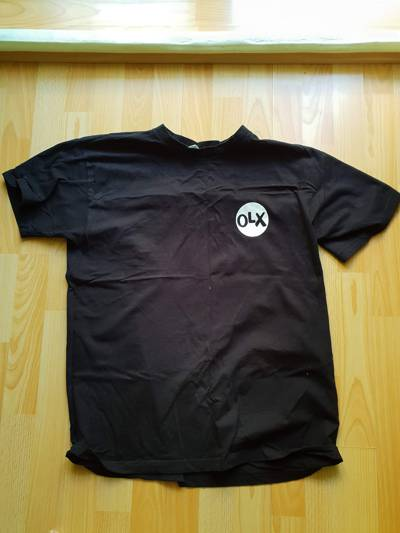

In [7]:
path = './clothing-dataset-small/train/t-shirt'
name = '5f0a3fa0-6a3d-4b68-b213-72766a643de7.jpg'
fullname = f'{path}/{name}'
load_img(fullname)

In [8]:
img = load_img(fullname, target_size=(299, 299))

In [9]:
x = np.array(img)
x.shape # 3 indicates an RGB photo

(299, 299, 3)

## Pre-trained convolutional neural networks

In [3]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.xception import decode_predictions

In [5]:
model = Xception(weights='imagenet', input_shape=(299, 299, 3))

91884032/91884032 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
X = np.array([x])
X.shape

(1, 299, 299, 3)

In [11]:
X = preprocess_input(X)

In [12]:
pred = model.predict(X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


In [13]:
decode_predictions(pred)

35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


[[('n03595614', 'jersey', 0.68196356),
  ('n02916936', 'bulletproof_vest', 0.038139995),
  ('n04370456', 'sweatshirt', 0.034324735),
  ('n03710637', 'maillot', 0.011354207),
  ('n04525038', 'velvet', 0.0018453562)]]

## Transfer learning

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [15]:
# Create an ImageDataGenerator for training data
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Load the training dataset from the specified directory
train_ds = train_gen.flow_from_directory(
    './clothing-dataset-small/train',
    target_size=(150, 150), # Resize images to 150x150
    batch_size=32
)

Found 3068 images belonging to 10 classes.


In [16]:
train_ds.class_indices

{'dress': 0,
 'hat': 1,
 'longsleeve': 2,
 'outwear': 3,
 'pants': 4,
 'shirt': 5,
 'shoes': 6,
 'shorts': 7,
 'skirt': 8,
 't-shirt': 9}

In [17]:
X, y = next(train_ds)
y[:5]

array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]], dtype=float32)

In [18]:
# Create an ImageDataGenerator for validation data
val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Load the validation dataset from the specified directory
val_ds = val_gen.flow_from_directory(
    './clothing-dataset-small/validation',
    target_size=(150, 150), # Resize images to 150x150
    batch_size=32,
    shuffle=False # Do not shuffle data; ensures reproducibility
)

Found 341 images belonging to 10 classes.


In [ ]:
# Define the input layer for the model
# The input shape matches the shape of the images (150x150 pixels with 3 color channels)
inputs = keras.Input(shape=(150, 150, 3))

# Pass inputs through the pre-trained Xception model without updating its weights
base = base_model(inputs, training=False)

# Apply global average pooling to the output of the base model
# This reduces the spatial dimensions of the feature maps to a single vector per feature map
vectors = keras.layers.GlobalAveragePooling2D()(base)

# Dense layer: Adds a fully connected layer with 10 outputs (number of classes)
outputs = keras.layers.Dense(10)(vectors)

# Combine the input and output layers into a final model
model = keras.Model(inputs, outputs)

In [ ]:
# Load the pre-trained Xception model
base_model = Xception(
    weights='imagenet',
    include_top=False, # Exclude the top (fully connected) layers for custom training
    input_shape=(150, 150, 3)
)

# Freeze the base model's layers
# This prevents the weights of the pre-trained layers from being updated during training
base_model.trainable = False

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
learning_rate = 0.01
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

loss = keras.losses.CategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [ ]:
history = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 341s 4s/step - accuracy: 0.9478 - loss: 0.1443 - val_accuracy: 0.8065 - val_loss: 0.9571
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 340s 4s/step - accuracy: 0.9772 - loss: 0.0763 - val_accuracy: 0.7918 - val_loss: 0.9453
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 383s 4s/step - accuracy: 0.9792 - loss: 0.0713 - val_accuracy: 0.8299 - val_loss: 0.9740
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 341s 4s/step - accuracy: 0.9911 - loss: 0.0367 - val_accuracy: 0.8035 - val_loss: 0.9585
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 334s 3s/step - accuracy: 0.9915 - loss: 0.0365 - val_accuracy: 0.8006 - val_loss: 0.9774
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 379s 3s/step - accuracy: 0.9887 - loss: 0.0395 - val_accuracy: 0.7859 - val_loss: 0.9868
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 382s 3s/step - accuracy: 0.9972 - loss: 0.0185 - val_accuracy: 0.7918 - val_loss: 1.0424
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 380s 3s/step - accuracy: 0.9947 - loss: 0.0295 - val_accuracy: 0.8123 - v

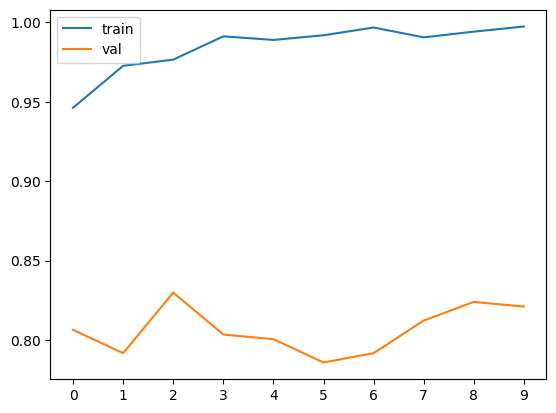

In [ ]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xticks(np.arange(10))
plt.legend()

## Adjusting the learning rate

In [ ]:
def make_model(learning_rate=0.01):
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(150, 150, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    outputs = keras.layers.Dense(10)(vectors)
    model = keras.Model(inputs, outputs)

    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )

    return model

In [ ]:
scores = {}

for lr in [0.0001, 0.001, 0.01, 0.1]:
    print(lr)

    model = make_model(learning_rate=lr)
    history = model.fit(train_ds, epochs=10, validation_data=val_ds)
    scores[lr] = history.history

    print()
    print()

0.0001
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


96/96 ━━━━━━━━━━━━━━━━━━━━ 381s 4s/step - accuracy: 0.1950 - loss: 2.3294 - val_accuracy: 0.4751 - val_loss: 1.6906
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 374s 4s/step - accuracy: 0.5068 - loss: 1.5166 - val_accuracy: 0.6188 - val_loss: 1.3076
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 363s 4s/step - accuracy: 0.6175 - loss: 1.2128 - val_accuracy: 0.6804 - val_loss: 1.1092
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 356s 4s/step - accuracy: 0.6931 - loss: 1.0222 - val_accuracy: 0.7361 - val_loss: 0.9877
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 354s 4s/step - accuracy: 0.7239 - loss: 0.9299 - val_accuracy: 0.7214 - val_loss: 0.9169
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 356s 4s/step - accuracy: 0.7468 - loss: 0.8336 - val_accuracy: 0.7449 - val_loss: 0.8586
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 355s 4s/step - accuracy: 0.7704 - loss: 0.7745 - val_accuracy: 0.7419 - val_loss: 0.8152
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 380s 4s/step - accuracy: 0.7746 - loss: 0.7329 - val_accuracy: 0.7537 - val_loss: 0.

In [ ]:
for lr, hist in scores.items():
    plt.plot(hist['accuracy'], label=('train=%s' % lr))
    plt.plot(hist['val_accuracy'], label=('val=%s' % lr))

plt.xticks(np.arange(10))
plt.legend()

In [ ]:
del scores[0.1]
del scores[0.0001]

In [ ]:
for lr, hist in scores.items():
    plt.plot(hist['accuracy'], label=('train=%s' % lr))
    plt.plot(hist['val_accuracy'], label=('val=%s' % lr))

plt.xticks(np.arange(10))
plt.legend()

In [ ]:
#Choosing the best lr
learning_rate = 0.001

## Checkpointing

In [ ]:
chechpoint = keras.callbacks.ModelCheckpoint(
    'xception_v1_{epoch:02d}_{val_accuracy:.3f}.model.keras', # Filename format with epoch and val_accuracy
    save_best_only=True, # Only save the best model (based on the monitored metric)
    monitor='val_accuracy', # Metric to monitor for improvements
    mode='max' # Looks for the maximum value of val_accuracy
)

In [ ]:
learning_rate = 0.001

model = make_model(learning_rate=learning_rate)

history = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks=[chechpoint]
)

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 356s 4s/step - accuracy: 0.5376 - loss: 1.3763 - val_accuracy: 0.7537 - val_loss: 0.7350
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 381s 4s/step - accuracy: 0.8099 - loss: 0.5970 - val_accuracy: 0.7977 - val_loss: 0.6256
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 357s 4s/step - accuracy: 0.8282 - loss: 0.4983 - val_accuracy: 0.7977 - val_loss: 0.5909
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 345s 4s/step - accuracy: 0.8663 - loss: 0.4205 - val_accuracy: 0.7977 - val_loss: 0.5732
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 388s 4s/step - accuracy: 0.8961 - loss: 0.3575 - val_accuracy: 0.8006 - val_loss: 0.5514
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 350s 4s/step - accuracy: 0.9169 - loss: 0.3089 - val_accuracy: 0.7977 - val_loss: 0.5605
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 347s 4s/step - accuracy: 0.9137 - loss: 0.2938 - val_accuracy: 0.8035 - val_loss: 0.5422
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 347s 4s/step - accuracy: 0.9376 - loss: 0.2627 - val_accuracy: 0.8358 - v

## Adding more layers

In [ ]:
def make_model(learning_rate=0.01, size_inner=100):
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(150, 150, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False) # Pass inputs through the frozen base model
    vectors = keras.layers.GlobalAveragePooling2D()(base) # Pool feature maps into a single vector

    inner = keras.layers.Dense(size_inner, activation='relu')(vectors) # Hidden dense layer

    outputs = keras.layers.Dense(10)(inner) # Final dense layer with 10 outputs (for 10 classes)

    model = keras.Model(inputs, outputs) # Combine inputs and outputs into a model

    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )

    return model

In [ ]:
learning_rate = 0.001

scores = {}

for size in [10, 100, 1000]:
    print(size)

    model = make_model(learning_rate=learning_rate, size_inner=size)
    history = model.fit(train_ds, epochs=10, validation_data=val_ds)
    scores[size] = history.history

    print()
    print()

10
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


96/96 ━━━━━━━━━━━━━━━━━━━━ 313s 3s/step - accuracy: 0.3355 - loss: 1.9370 - val_accuracy: 0.5513 - val_loss: 1.3312
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 310s 3s/step - accuracy: 0.6265 - loss: 1.2021 - val_accuracy: 0.6774 - val_loss: 1.0270
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 296s 3s/step - accuracy: 0.7122 - loss: 0.9055 - val_accuracy: 0.7126 - val_loss: 0.8654
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 295s 3s/step - accuracy: 0.7678 - loss: 0.7444 - val_accuracy: 0.7449 - val_loss: 0.7815
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 299s 3s/step - accuracy: 0.7868 - loss: 0.6753 - val_accuracy: 0.7947 - val_loss: 0.7242
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 317s 3s/step - accuracy: 0.8230 - loss: 0.5605 - val_accuracy: 0.7625 - val_loss: 0.7057
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 323s 3s/step - accuracy: 0.8436 - loss: 0.5003 - val_accuracy: 0.7801 - val_loss: 0.6984
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 299s 3s/step - accuracy: 0.8623 - loss: 0.4701 - val_accuracy: 0.7977 - val_loss: 0.

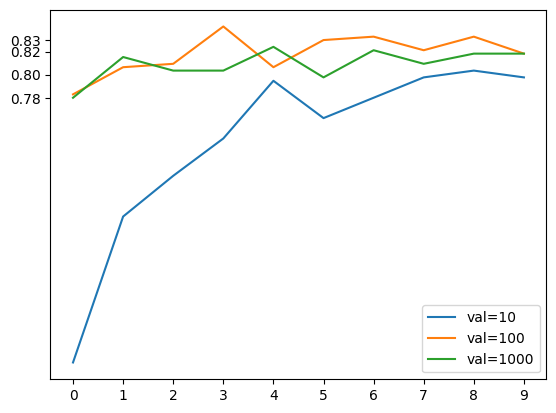

In [ ]:
for size, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % size))

plt.xticks(np.arange(10))
plt.yticks([0.78, 0.80, 0.82, 0.83])
plt.legend()

## Regularization and dropout

In [19]:
def make_model(learning_rate=0.01, size_inner=100, droprate=0.5):
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(150, 150, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)

    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    drop = keras.layers.Dropout(droprate)(inner)

    outputs = keras.layers.Dense(10)(drop)

    model = keras.Model(inputs, outputs)

    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )

    return model

In [ ]:
# Set the learning rate for the model
learning_rate = 0.001

# Define the size of the inner layers of the model
size = 100

# Initialize an empty dictionary to store the training history for different dropout rates
scores = {}

# Iterate over different dropout rates to evaluate model performance
for droprate in [0.0, 0.2, 0.5, 0.8]:
    print(droprate)  # Print the current dropout rate being used

    # Create a new model instance with the specified parameters
    model = make_model(
        learning_rate=learning_rate,  # Pass the learning rate to the model
        size_inner=size,             # Pass the inner layer size to the model
        droprate=droprate            # Pass the current dropout rate to the model
    )

    # Train the model using the training dataset and validate on the validation dataset
    history = model.fit(train_ds, epochs=30, validation_data=val_ds)

    # Store the training history for the current dropout rate in the scores dictionary
    scores[droprate] = history.history

    # Print an empty line to improve readability of the output
    print()
    print()

0.0
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


96/96 ━━━━━━━━━━━━━━━━━━━━ 35s 229ms/step - accuracy: 0.5604 - loss: 1.3304 - val_accuracy: 0.7801 - val_loss: 0.6615
Epoch 2/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - accuracy: 0.8301 - loss: 0.4826 - val_accuracy: 0.8240 - val_loss: 0.5868
Epoch 3/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 76ms/step - accuracy: 0.8802 - loss: 0.3678 - val_accuracy: 0.8182 - val_loss: 0.5316
Epoch 4/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - accuracy: 0.9288 - loss: 0.2415 - val_accuracy: 0.7889 - val_loss: 0.5925
Epoch 5/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - accuracy: 0.9454 - loss: 0.1920 - val_accuracy: 0.8475 - val_loss: 0.5427
Epoch 6/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 76ms/step - accuracy: 0.9790 - loss: 0.1129 - val_accuracy: 0.8094 - val_loss: 0.5833
Epoch 7/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 11s 81ms/step - accuracy: 0.9850 - loss: 0.0865 - val_accuracy: 0.8123 - val_loss: 0.5692
Epoch 8/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - accuracy: 0.9940 - loss: 0.0567 - val_accuracy: 0.8387 - val_loss:

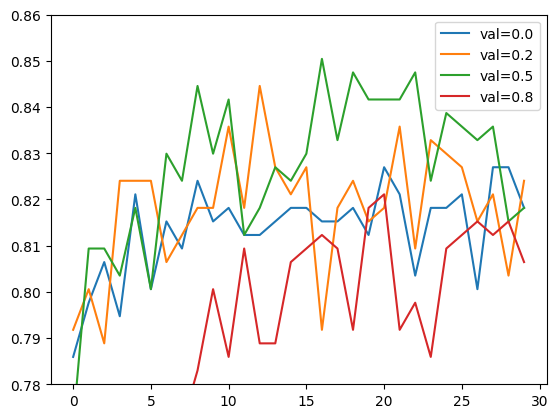

In [ ]:
for droprate, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % droprate))

plt.ylim(0.78, 0.86)
plt.legend()

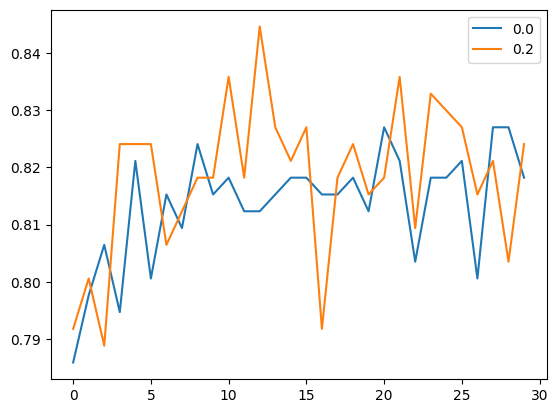

In [ ]:
hist = scores[0.0]
plt.plot(hist['val_accuracy'], label=0.0)

hist = scores[0.2]
plt.plot(hist['val_accuracy'], label=0.2)

plt.legend()

## Data augmentation

In [ ]:
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
#     vertical_flip=True,
)

train_ds = train_gen.flow_from_directory(
    './clothing-dataset-small/train',
    target_size=(150, 150),
    batch_size=32
)

val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = val_gen.flow_from_directory(
    './clothing-dataset-small/validation',
    target_size=(150, 150),
    batch_size=32,
    shuffle=False
)

Found 3068 images belonging to 10 classes.
Found 341 images belonging to 10 classes.


In [ ]:
learning_rate = 0.001
size = 100
droprate = 0.2

model = make_model(
    learning_rate=learning_rate,
    size_inner=size,
    droprate=droprate
)

history = model.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 21s 150ms/step - accuracy: 0.5385 - loss: 1.3546 - val_accuracy: 0.7859 - val_loss: 0.6764
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 13s 88ms/step - accuracy: 0.7832 - loss: 0.6278 - val_accuracy: 0.8094 - val_loss: 0.5894
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - accuracy: 0.8520 - loss: 0.4399 - val_accuracy: 0.8094 - val_loss: 0.6133
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 97ms/step - accuracy: 0.8823 - loss: 0.3421 - val_accuracy: 0.8182 - val_loss: 0.5702
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - accuracy: 0.9241 - loss: 0.2583 - val_accuracy: 0.8065 - val_loss: 0.5891
Epoch 6/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step - accuracy: 0.9317 - loss: 0.2265 - val_accuracy: 0.8211 - val_loss: 0.5635
Epoch 7/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 97ms/step - accuracy: 0.9520 - loss: 0.1733 - val_accuracy: 0.8182 - val_loss: 0.5746
Epoch 8/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - accuracy: 0.9519 - loss: 0.1463 - val_accuracy: 0.82

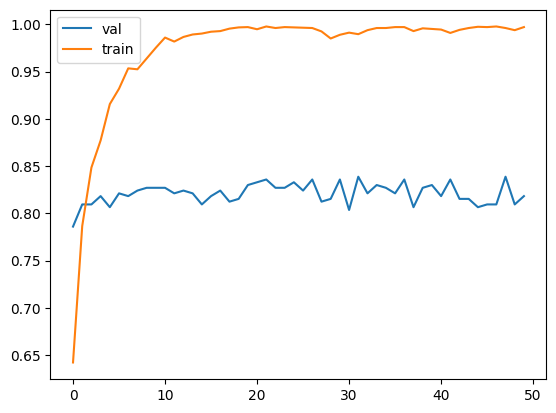

In [ ]:
hist = history.history
plt.plot(hist['val_accuracy'], label='val')
plt.plot(hist['accuracy'], label='train')

plt.legend()

## Training a larger model

In [20]:
def make_model(input_size=150, learning_rate=0.01, size_inner=100,
               droprate=0.5):

    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(input_size, input_size, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(input_size, input_size, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)

    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    drop = keras.layers.Dropout(droprate)(inner)

    outputs = keras.layers.Dense(10)(drop)

    model = keras.Model(inputs, outputs)

    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )

    return model

In [21]:
input_size = 299

In [22]:
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=10,
    zoom_range=0.1,
    horizontal_flip=True
)

train_ds = train_gen.flow_from_directory(
    './clothing-dataset-small/train',
    target_size=(input_size, input_size),
    batch_size=32
)


val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = train_gen.flow_from_directory(
    './clothing-dataset-small/validation',
    target_size=(input_size, input_size),
    batch_size=32,
    shuffle=False
)

Found 3068 images belonging to 10 classes.
Found 341 images belonging to 10 classes.


In [23]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_v4_1_{epoch:02d}_{val_accuracy:.3f}.model.keras',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

In [24]:
learning_rate = 0.0005
size = 100
droprate = 0.2

model = make_model(
    input_size=input_size,
    learning_rate=learning_rate,
    size_inner=size,
    droprate=droprate
)

history = model.fit(train_ds, epochs=50, validation_data=val_ds,
                   callbacks=[checkpoint])

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


96/96 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - accuracy: 0.5602 - loss: 1.4000 - val_accuracy: 0.8299 - val_loss: 0.5563
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 88s 743ms/step - accuracy: 0.8164 - loss: 0.5485 - val_accuracy: 0.8739 - val_loss: 0.4312
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 75s 733ms/step - accuracy: 0.8457 - loss: 0.4381 - val_accuracy: 0.8651 - val_loss: 0.4273
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 82s 743ms/step - accuracy: 0.8689 - loss: 0.3706 - val_accuracy: 0.8739 - val_loss: 0.3878
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 82s 730ms/step - accuracy: 0.8744 - loss: 0.3568 - val_accuracy: 0.8534 - val_loss: 0.4089
Epoch 6/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 78s 771ms/step - accuracy: 0.8933 - loss: 0.3093 - val_accuracy: 0.8710 - val_loss: 0.3945
Epoch 7/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 79s 736ms/step - accuracy: 0.9070 - loss: 0.2855 - val_accuracy: 0.8563 - val_loss: 0.4268
Epoch 8/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 76s 736ms/step - accuracy: 0.8946 - loss: 0.2778 - val_accuracy: 0.8592 

## Using the model

In [25]:
import tensorflow as tf
from tensorflow import keras

In [26]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img

from tensorflow.keras.applications.xception import preprocess_input

In [27]:
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_ds = test_gen.flow_from_directory(
    './clothing-dataset-small/test',
    target_size=(299, 299),
    batch_size=32,
    shuffle=False
)

Found 372 images belonging to 10 classes.


In [28]:
model = keras.models.load_model('xception_v4_1_42_0.897.model.keras')

In [29]:
model.evaluate(test_ds)

12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.8749 - loss: 0.3484


[0.2623618245124817, 0.9086021780967712]

In [30]:
path = 'clothing-dataset-small/test/pants/c8d21106-bbdb-4e8d-83e4-bf3d14e54c16.jpg'

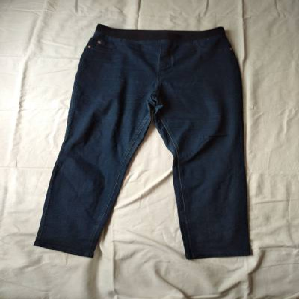

In [31]:
load_img(path, target_size=(299, 299))

In [32]:
img = load_img(path, target_size=(299, 299))

In [33]:
import numpy as np

In [34]:
x = np.array(img)
X = np.array([x])
X.shape

(1, 299, 299, 3)

In [35]:
X = preprocess_input(X)
pred = model.predict(X)

classes = [
    'dress',
    'hat',
    'longsleeve',
    'outwear',
    'pants',
    'shirt',
    'shoes',
    'shorts',
    'skirt',
    't-shirt'
]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [36]:
dict(zip(classes, pred[0]))

{'dress': -4.718435,
 'hat': -9.798456,
 'longsleeve': -5.2296247,
 'outwear': -6.5659003,
 'pants': 10.829473,
 'shirt': -4.2961297,
 'shoes': -5.3124814,
 'shorts': 4.5652637,
 'skirt': -8.542514,
 't-shirt': -7.611872}